#### Modello Fiaschi 3.0

Struttura 2 W:

Anziche utilizzare la proiezione, impone la disuguaglianza $W_2^T * z^{(1)} > \lambda * \Delta_{W_2}L_2 * z^{(1)} $

In [386]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import torch.linalg as linalg

dataset = torch.tensor([[0.,8.],[1.,8.],[2.,8.],[3.,8.],[4.,8.],
                        [0.,7.],[1.,7.],[2.,7.],[3.,7.],[4.,7.],
                        [0.,6.],[1.,6.],[2.,6.],[3.,6.],[4.,6.],
                        [0.,5.],[1.,5.],[2.,5.],[3.,5.],[4.,5.],
                        [0.,4.],[1.,4.],[2.,4.],[3.,4.],[4.,4.],
                        [0.,3.],[1.,3.],[2.,3.],[3.,3.],[4.,3.],
                        [0.,2.],[1.,2.],[2.,2.],[3.,2.],[4.,2.],
                        [0.,1.],[1.,1.],[2.,1.],[3.,1.],[4.,1.]])

labels = torch.tensor(  [0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,1.,0.,0.,
                         1.,1.,1.,0.,1.,
                         1.,1.,0.,1.,1.,
                         1.,1.,1.,1.,1.,
                         1.,1.,1.,1.,1.])

train_data = []
train_data0 = []
train_data1 = []

for i in range(len(dataset)):
   train_data.append([dataset[i], labels[i]])
   if labels[i] == 0:
      train_data0.append([dataset[i], labels[i]])
   elif labels[i] == 1:
      train_data1.append([dataset[i], labels[i]])

In [387]:
class ModelloF(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size):
        super(ModelloF, self).__init__()
        self.loss = torch.nn.BCEWithLogitsLoss()

        self.W1 = torch.nn.Linear(input_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.ReLU = torch.nn.ReLU()

        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.Adam(self.parameters())
        
    def forward(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R(W1 * x)))
        '''
        
        k = self.W1(x)
        z = self.ReLU(k)
        y = self.W2(z)

        return y, z.clone().detach()

# ----------------------------------------------------------

    def train(self, dl):
        for x,y in dl:
            self.optimizer.zero_grad()

            y_pred, _ = self(x)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()

        return e.detach().numpy()

    def train_L2(self, dl):
        for x,y in dl:
            self.optimizer.zero_grad()

            y_pred, _ = self(x)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()

            # ---
            
            pre = torch.matmul(self.W2.weight, self.save_z.T)
            post = torch.matmul(self.W2.weight.grad, self.save_z.T)

            grad = self.W2.weight.grad

            while not ((pre - post) > 2).all():
                grad = grad / 1.2
                post = torch.matmul(grad, self.save_z.T)

            for name, param in self.named_parameters():
                if name == 'W2.weight':
                    param.grad = grad
            
            # ---
            pre = torch.matmul(self.W2.weight, self.save_z.T)
            post = torch.matmul(self.W2.weight.grad, self.save_z.T)

            if ((pre - post) > 2).all():
                self.optimizer.step()

        return e.detach().numpy()
    
    def test(self,dl):
        '''  
        questa funzione testa il modello sul dataset in input usando il modello in modalità L1 (senza la matrice di proiezione)
        ''' 
        for x,y in dl:
            y_pred, _ = self(x)
            e = self.loss(y_pred,y.unsqueeze(1))
        return e.detach().numpy()

# ----------------------------------------------------------
    
    def generate_z(self, dl):
        base = None
        with torch.no_grad():
            for x,y in dl:  
                _, z = self(x)
                if base is None:
                    base = z
                else:
                    base = torch.cat((base, z.clone().detach()), dim = 0)
        
        self.save_z = base

In [388]:
#INIZIALIZZAZIONE SEED, MODELLO E DATALOADERS

torch.manual_seed(66)
modello = ModelloF(2,1,100)
dl0 = torch.utils.data.DataLoader(train_data0, batch_size = 8, shuffle = True)
dl1 = torch.utils.data.DataLoader(train_data1, batch_size = 8, shuffle = True)

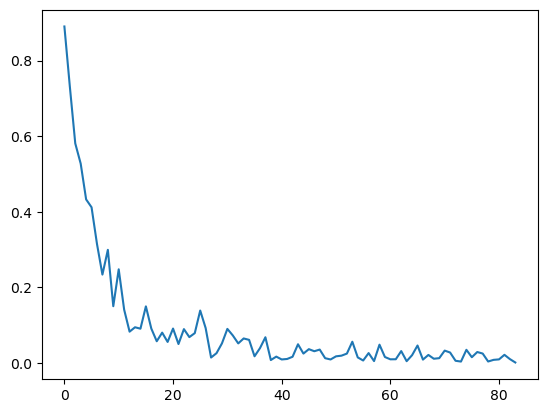

In [389]:
#TRAIN FASE 1
e = 1
err = []
while e > 1e-3:
    e = modello.train(dl1)
    err.append(e) 

plt.plot([x for x in range(len(err))], err, label = "Loss")
plt.show()

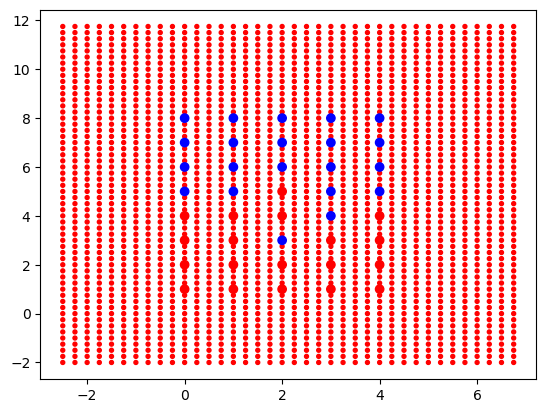

In [390]:
#PLOT FASE 1

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < 0.45 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione

In [391]:
modello.generate_z(dl1)

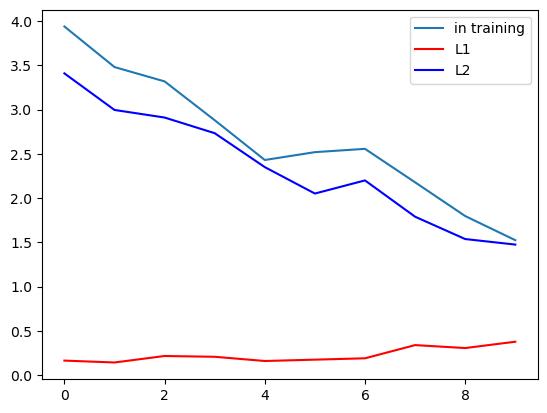

In [395]:
#TRAIN FASE 2

err = []
err_L1 = []
err_L2 = []

for _ in range(10):
    e = modello.train_L2(dl0)
    err.append(e)
    e_L1 = modello.test(dl1)
    err_L1.append(e_L1)
    e_L2 = modello.test(dl0)
    err_L2.append(e_L2)
plt.plot([x for x in range(len(err))], err,label='in training')
plt.plot([x for x in range(len(err_L1))], err_L1,label='L1',color='red')
plt.plot([x for x in range(len(err_L2))], err_L2,label='L2',color = 'blue')
plt.legend()
plt.show()

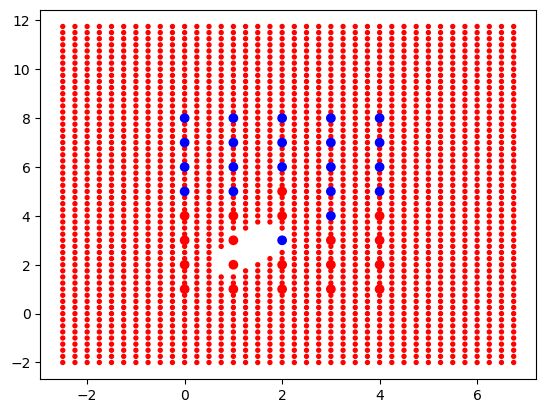

In [396]:
#PLOT FASE 2

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] < 0.45 else 'red' if p[2][0] > 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione